# Preliminaries
In this tutorial we will check out the 🤗 Datasets library, how to work with datasets obtained through HuggingFace and the kind of preprocessing that the library enables before piping your data into your training pipeline. We are going to deal with loading and processing existing data, streaming datasets which are too big for local memory, slice and dicing and further manipulating a dataset. In a second section we will also look at tokenization as the core preprocessing step for NLP and how to apply different tokenizers and perform tasks such as encoding and decoding.

Parts of this tutorial is guided by the official [HuggingFace Datasets Documentation](https://huggingface.co/docs/datasets/v2.20.0/en/index). Check it out to learn what other things you can do with the help of the library.

First, make sure we have installed all the relevant libraries.

In [ ]:
! pip install transformers[torch] datasets tf-keras

# Handling Data with Huggingface

## Loading local data

In [1]:
from transformers import AutoTokenizer
from datasets import load_dataset

We want to load a NLP dataset to work with it. We will choose the [drugsCom dataset](https://archive.ics.uci.edu/dataset/462/drug+review+dataset+drugs+com), a dataset of patient reviews of medication. 

Let's download and prepare the data.

In [ ]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip drugsCom_raw.zip

We will use the 🤗 Datasets library to load and deal with our local data. 

We will parse both train and test sets into a single DatasetDict object first.

In [2]:
data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}

drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

Let's check out some stats about our dataset:

In [3]:
drug_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

We can easily get an idea about the dataset from this including the size, number of instances, the train and test split and the different fields present.

Let's look at some examples of the dataset in more detail:

In [4]:
drug_sample = drug_dataset["train"].shuffle(seed=42).select(range(1000))
# Peek at the first few examples
drug_sample[:3]

{'Unnamed: 0': [87571, 178045, 80482],
 'drugName': ['Naproxen', 'Duloxetine', 'Mobic'],
 'condition': ['Gout, Acute', 'ibromyalgia', 'Inflammatory Conditions'],
 'review': ['"like the previous person mention, I&#039;m a strong believer of aleve, it works faster for my gout than the prescription meds I take. No more going to the doctor for refills.....Aleve works!"',
  '"I have taken Cymbalta for about a year and a half for fibromyalgia pain. It is great\r\nas a pain reducer and an anti-depressant, however, the side effects outweighed \r\nany benefit I got from it. I had trouble with restlessness, being tired constantly,\r\ndizziness, dry mouth, numbness and tingling in my feet, and horrible sweating. I am\r\nbeing weaned off of it now. Went from 60 mg to 30mg and now to 15 mg. I will be\r\noff completely in about a week. The fibro pain is coming back, but I would rather deal with it than the side effects."',
  '"I have been taking Mobic for over a year with no side effects other than 

The 'Unnamed: 0' column does not have a proper name. Let's fix this. Our assumption is that this could serve as a unique identifier for our datapoints. 

Let's check if that asummption holds:

In [5]:
for split in drug_dataset.keys():
    assert len(drug_dataset[split]) == len(drug_dataset[split].unique("Unnamed: 0"))

All values seem to be unique. Let's make this our id field and rename the column. This works with the *rename_column* method

In [6]:
drug_dataset = drug_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="patient_id"
)
drug_dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

One of the strongest suits of the Datasets library is that it enables us to apply transformations to our whole dataset comfortably.

If we check the condition column above we can see that some instances are written in upper case and some in lower case. Let's fix this by unifying the condition labels to all lowercase. 

Go ahead and use the [Datasets Map](https://huggingface.co/docs/datasets/v2.1.0/en/process#map) functions for this and overwriting the existing field.

In [7]:
def lowercase_condition(example):
    return {"condition": example["condition"].lower()}

### TODO: Apply the lowercasing function to our whole dataset.
drug_dataset.map(lowercase_condition)

Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

AttributeError: 'NoneType' object has no attribute 'lower'

Woops something went wrong! Turns out some fields do not have an entry in the condition column.

We can use the [filter](https://huggingface.co/docs/datasets/en/process#select-and-filter) function to help us with this.

Let's filter the dataset and only keep entries with a valid condition.

In [8]:
### TODO: filter the dataset to only keep rows with an entry in the condition column

drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)

After applying the filter we can check if we can now do the lowercase transformation:

In [9]:
drug_dataset = drug_dataset.map(lowercase_condition)
# Check that lowercasing worked
drug_dataset["train"]["condition"][:3]

['left ventricular dysfunction', 'adhd', 'birth control']

Looks like everything is set.

We can also do some column selection. Let's say we only need to keep a couple of fields for our processing and toss the rest for now:

In [10]:
drug_dataset = drug_dataset.select_columns(['condition', 'review', 'patient_id'])

We want to know how long individual reviews are. Something we can also easily compute through mapping. 

We will store the length in a new column called *review_length*

In [11]:
def compute_review_length(example):
    return {"review_length": len(example["review"].split())}

drug_dataset = drug_dataset.map(compute_review_length)
# Inspect the first training example
drug_dataset["train"][0]

{'condition': 'left ventricular dysfunction',
 'review': '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
 'patient_id': 206461,
 'review_length': 17}

Let's check out some of those shorter reviews:

In [12]:
drug_dataset["train"].sort("review_length")[:3]

{'condition': ['hepatitis c', 'adhd', 'birth control'],
 'review': ['"Headache"', '"Great"', '"Awesome"'],
 'patient_id': [111469, 13653, 53602],
 'review_length': [1, 1, 1]}

A lot of short reviews only seem to have one word. That might not be super useful for us. 

Let's apply a filter to sort reviews that are 30 words or longer and see how much we got rid of:

In [13]:
print(drug_dataset.num_rows)
### TODO: Filter the dataset for reviews of at least 30 words.
drug_dataset = drug_dataset.filter(lambda x: x["review_length"] > 30)
print(drug_dataset.num_rows)

{'train': 160398, 'test': 53471}
{'train': 138514, 'test': 46108}


We lost a lost a reasonable chunk, but not too many. 

In some cases we might benefit for doing some sanitization of our training data, depending on the task we want to solve.

## Datasets on Huggingface

Check our the following Page: [Dataset Tagger](https://huggingface.co/spaces/huggingface/datasets-tagging)

Huggingface provides a guideline for the kind of information a dataset should collect when uploading to its platform. We can also quickly check already existing datasets on there and look at their tags as well.

TODO: Check the Rotten Tomatoes dataset. 

Can you answer the following questions: How big is the dataset? What task is it for? Does it have labels? Who labeled the dataset?

When you want to upload your own data there is also this helpful guide in what you should consider documenting: [Dataset Card Creation Guide](https://github.com/huggingface/datasets/blob/main/templates/README_guide.md)

We want to load the training set of the Rotten Tomatoes dataset directly into our notebook. Check out the [guide](https://huggingface.co/docs/datasets/en/loading) on loading from external sources as well.

In [14]:
from datasets import get_dataset_split_names

print(get_dataset_split_names("rotten_tomatoes"))
## TODO: Load the train set into local memory
rotten_tomatoes = load_dataset("rotten_tomatoes", split="train")
rotten_tomatoes

['train', 'validation', 'test']


Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})

Let's check what columns exist in this dataset:

In [15]:
rotten_tomatoes.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

We can do some specific data point selection if we wish:

In [16]:
selected_dataset = rotten_tomatoes.select([0, 10, 20, 30, 40, 50])
selected_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 6
})

We can also shard the dataset and split it into equal sized parts. Note that the method will return a specific shard if specified.

In [17]:
print(rotten_tomatoes)
shard_zero = rotten_tomatoes.shard(num_shards=4, index=0)
shard_zero

Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})


Dataset({
    features: ['text', 'label'],
    num_rows: 2133
})

A useful tool for data manipulation can be to shuffle the whole dataset for random selection:

In [18]:
shuffled_tomatoes = rotten_tomatoes.shuffle(seed=42)

We can also do our own splits of the dataset with built-in functions.

Do the split of the dataset and choose an 80/20 split for train and test. Check out the relevant [docs](https://huggingface.co/docs/datasets/en/package_reference/main_classes)

In [19]:
rt_train_test_split = shuffled_tomatoes.train_test_split(test_size=0.2) # TODO: Split the shuffled dataset
rt_train_dataset = rt_train_test_split['train']
rt_validation_dataset = rt_train_test_split['test']

print(f"New training set size: {len(rt_train_dataset)}")
print(f"Validation set size: {len(rt_validation_dataset)}")

New training set size: 6824
Validation set size: 1706


With this we have easily split our dataset into a new train and validation split for training. 

Note that the split produced a DatasetDict, not a Dataset object.

### Visualization for our data

In some cases it makes sense to generate some easy visualizations to check on our labels and other details. We can easily convert our Huggingface Dataset into a pandas Dataframe for this.

<Axes: title={'center': 'Distribution of Labels'}, xlabel='Label', ylabel='Count'>

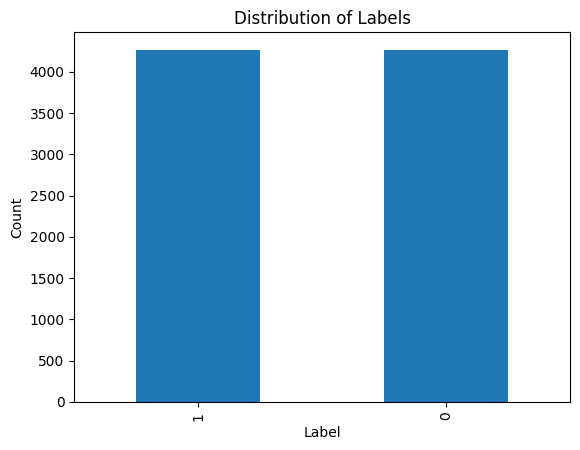

In [20]:
import pandas as pd

# Convert to pandas DataFrame
df = pd.DataFrame(rotten_tomatoes)

# Plot the distribution of labels
label_counts = df['label'].value_counts()
label_counts.plot(kind='bar', title='Distribution of Labels', xlabel='Label', ylabel='Count')

Let's also check on review length distribution visually. We can do this with a histogram.

<Axes: title={'center': 'Distribution of Text Lengths'}, xlabel='Length', ylabel='Frequency'>

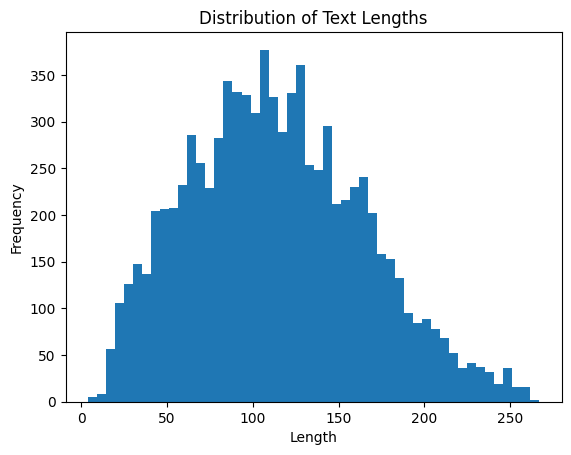

In [21]:
# TODO: Calculate the length of each review and store it in the dataframe
df['text_length'] = df['text'].apply(len)

# TODO: Plot the distribution of text lengths as a histogram.
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.hist.html
df['text_length'].plot(kind='hist', bins=50, title='Distribution of Text Lengths', xlabel='Length', ylabel='Frequency')

## Semantic Data Augmentation 

Let's say we think our Rotten Tomatoes dataset is too small for us. We can try to apply some easy augmentation strategies to generate more data for us.

For this we will make use of a roberta-model and an existing transformer doing what Roberta can do very well: Masked language modeling.

In [22]:
from random import randint
from transformers import pipeline

fillmask = pipeline("fill-mask", model="roberta-base")
mask_token = fillmask.tokenizer.mask_token
# We'll only do it on a subset here to save some compute time.
smaller_dataset = rotten_tomatoes.filter(lambda e, i: i<100, with_indices=True)

2024-06-14 12:49:21.478421: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 12:49:22.441022: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Let's check out one of the reviews in our subset:

In [23]:
smaller_dataset[3]

{'text': 'if you sometimes like to go to the movies to have fun , wasabi is a good place to start .',
 'label': 1}

To do augmentation with Roberta, we will first choose a random word in our reviews to mask and then let our pipeline do a couple of predictions for each.

In [24]:
### TODO: Apply the Roberta model to our masked sentences and return the newly generated data.

def augment_data(examples):
    outputs = []
    for sentence in examples["text"]:
        words = sentence.split(' ')
        K = randint(1, len(words)-1)
        masked_sentence = " ".join(words[:K]  + [mask_token] + words[K+1:])
        predictions = fillmask(masked_sentence) # apply the model
        augmented_sequences = [predictions[i]["sequence"] for i in range(3)] # generate augmented data
        outputs += [sentence] + augmented_sequences
    return {"data": outputs}

In [25]:
augmented_dataset = smaller_dataset.map(augment_data, batched=True, remove_columns=rotten_tomatoes.column_names, batch_size=8)
augmented_dataset[12:24]["data"]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

['if you sometimes like to go to the movies to have fun , wasabi is a good place to start .',
 'if you sometimes like to go to the movies to have fun, wasabi is a good place to start.',
 'if you sometimes like to go to the movies to have fun, wasabi are a good place to start.',
 'if you sometimes like to go to the movies to have fun, wasabi seems a good place to start.',
 "emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .",
 "emerges as something rare, an issue movie that's so honest and keenly observed that it can feel like one.",
 "emerges as something rare, an issue movie that's so honest and keenly observed that it almost feel like one.",
 "emerges as something rare, an issue movie that's so honest and keenly observed that it does feel like one.",
 'the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .',
 'the film provides some great in

We managed to generate some extra sentences. Since we only replace single words it's sometimes not easy to spot the differences and in some cases the original sentence will be recreated as well (if it is the most likely sentence after all).

Q: Rotten Tomatoes What problems can you envision with this dataset and this Augmentation strategy?

The Rotten Tomatoes dataset is a sentiment analysis dataset. Changing single words could in some cases actually affect the predicted polarity. Our labels will not reflect this.

## Handling large datasets

Let's check out the following dataset that is available on HuggingFace: [The Pile](https://huggingface.co/datasets/EleutherAI/the_pile_deduplicated)

This thing is huge. 451 GB of text data. Even if we downloaded the whole thing to our machine, we will likely run into problems.

Load the dataset in a way that is feasible for your machine. Check out the [following documentation](https://huggingface.co/docs/datasets/en/stream) on loading bigger datasets.

In [26]:
### TODO: Load the dataset smartly you don't crash your notebook.
large_dataset = load_dataset(
    "EleutherAI/the_pile_deduplicated",
    split="train",
    streaming=True,
)
next(iter(large_dataset))

Resolving data files:   0%|          | 0/1650 [00:00<?, ?it/s]

{'text': 'It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.\n\nThere’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.\n\nConcept\n\nWorking over the theme was probably one of the hardest tasks I had to face.\n\nOriginally, I had an idea of what kind of game I wanted to develop, gameplay wise – something with lots of enemies/actors, simple graphics, maybe set in space, controlled from a top-down view. I was confident I could fit any theme around it.\n\nIn the end, the problem with a theme like “Evolution” in a game is that evolution is unassisted. It happens through several seemingly random mutations over time, with the most apt permutation surviving. This genetic car simulator is, in my opinion, a great example of actual evolution of a species facing a challenge.

This worked out nice and we can actually work with this streamed dataset directly now.

To try it out you should now shuffle the dataset and get the first 5 entries. 

This seems risky with a 451 GB dataset, but the library does a lot of heavy lifting for us.

In [28]:
### TODO: Shuffle the dataset and grab the first 5 entries of the shuffled set into dataset_head
shuffled_dataset = large_dataset.shuffle(seed=42, buffer_size=100_000)
dataset_head = shuffled_dataset.take(5)

In [29]:
list(dataset_head)

[{'text': "1. Technical Field\nThe invention generally relates to the field of computer-assisted or computer-based speech recognition, and more specifically, to a method and system for improving recognition quality of a speech recognition system.\n2. Description of the Related Art\nConventional speech recognition systems (SRSs), in a very simplified view, can include a database of word pronunciations linked with word spellings. Other supplementary mechanisms can be used to exploit relevant features of a language and the context of an utterance. These mechanisms can make a transcription more robust. Such elaborate mechanisms, however, will not prevent a SRS from failing to accurately recognize a spoken word when the database of words does not contain the word, or when a speaker's pronunciation of the word does not agree with the pronunciation entry in the database. Therefore, collecting and extending vocabularies is of prime importance for the improvement of SRSs.\nPresently, vocabulari

Q: Why did the list command take significantly longer than the ones before? 

Lazy evaluation in Python.

In [30]:
# similarly it is quite fast to just declare these
train_dataset = shuffled_dataset.skip(1000)
validation_dataset = shuffled_dataset.take(1000)

## Preprocessing and Tokenization

Let's look at what needs to happen with our dataset before we actually pipe it into a ML model. 

For text data we often want to do some easy but important preprocessing steps converting strings of text into appropriate formats before training.

Let's check out how we could do this:

In [31]:
input_string = "Using a Transformer network is simple."

You've probably done easy string manipulation quite a bit before. 

Try an easy stock method to do tokenization in Python, so we can compare later.

In [32]:
tokenized_text = input_string.split()
print(tokenized_text)

['Using', 'a', 'Transformer', 'network', 'is', 'simple.']


Let's compare to one of the pretrained tokenizers. In this case we will go with a BERT tokenizer first.

In [33]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [34]:
tokens = tokenizer.tokenize(input_string)
tokens

['Using', 'a', 'Trans', '##former', 'network', 'is', 'simple', '.']

What differences can you see here? 

What influence is this likely to have during further processing?

We can also do more with our tokenizer, for instance encode our string into ID's.

In [35]:
ids = tokenizer.convert_tokens_to_ids(tokens)
ids

[7993, 170, 13809, 23763, 2443, 1110, 3014, 119]

Vice versa, decoding is also possible in an analogous way:

In [36]:
decoded_string = tokenizer.decode([7993, 170, 11303, 1200, 2443, 1110, 3014, 119])
decoded_string

'Using a transformer network is simple.'

You could even try decoding random integers. The encoding is entirely dependent on the trained vocabulary of our tokenizer.

In [37]:
tokenizer.decode([4403, 106, 1789, 9909, 1303, 106])

'Hey! Some privacy here!'

## Using Tokenizers on 🤗 Datasets

We want to apply tokenization to one of our datasets. Let's try it on the Rotten Tomatoes reviews from before.

Remember what our reviews look like:

In [38]:
rotten_tomatoes[0]

{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .',
 'label': 1}

We can apply the tokenizer to the text field. Notice we are not using the *tokenize* or *convert_tokens_to_ids* methods. What difference do we see?

In [39]:
tokenizer(rotten_tomatoes[0]["text"])

{'input_ids': [101, 1103, 2067, 1110, 17348, 1106, 1129, 1103, 6880, 1432, 112, 188, 1207, 107, 14255, 1389, 107, 1105, 1115, 1119, 112, 188, 1280, 1106, 1294, 170, 24194, 1256, 3407, 1190, 170, 11791, 5253, 188, 1732, 7200, 10947, 12606, 2895, 117, 179, 7766, 118, 172, 15554, 1181, 3498, 6961, 3263, 1137, 188, 1566, 7912, 14516, 6997, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

There is some extra stuff here we haven't seen before. 

We have a dictionary with *input_ids*, *token_type_ids* and *attention_mask* keys.
*token_type_ids* is what is also known as a sequence ID for BERT to signify the end of Sequence A and start of Sequence B. 

What is the attention mask for? Consider our review again with some slight modifications:

In [40]:
tokenized_string = tokenizer(rotten_tomatoes[0]["text"], padding=True, pad_to_multiple_of=8)
tokenized_string

{'input_ids': [101, 1103, 2067, 1110, 17348, 1106, 1129, 1103, 6880, 1432, 112, 188, 1207, 107, 14255, 1389, 107, 1105, 1115, 1119, 112, 188, 1280, 1106, 1294, 170, 24194, 1256, 3407, 1190, 170, 11791, 5253, 188, 1732, 7200, 10947, 12606, 2895, 117, 179, 7766, 118, 172, 15554, 1181, 3498, 6961, 3263, 1137, 188, 1566, 7912, 14516, 6997, 119, 102, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]}

In [41]:
tokenizer.decode(tokenized_string['input_ids'])

'[CLS] the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger, jean - claud van damme or steven segal. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

Here we see we have added some extra stuff including CLS and SEP tokens as well as padding. 

What does this tell you in conjunction with the attention mask?

The attention mask is configured to ignore PAD tokens, we could even modify this ourselves to not attend to specific parts of our input with our BERT model.

With this out of the way we can apply tokenization to our whole dataset using the map function again. Let's define an easy helper function for this.

In [42]:
def tokenization(example):
    return tokenizer(example["text"])
    
### TODO: Tokenize our whole rotten tomatoes dataset.
dataset = rotten_tomatoes.map(tokenization, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Lastly, we can also make it comfortable to prepare a dataset for a specific machine learning framework, such as torch.

In [43]:
dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
dataset.format['type']

'torch'

These preparation steps tie seamlessly into using your data with any torch models you might want to try out or train yourself.

## Training a Tokenizer on the Drug Dataset

Remember our drug dataset from before? We also want to use a tokenizer before working with this text. Let's check out some details again.

In [44]:
drug_dataset

DatasetDict({
    train: Dataset({
        features: ['condition', 'review', 'patient_id', 'review_length'],
        num_rows: 138514
    })
    test: Dataset({
        features: ['condition', 'review', 'patient_id', 'review_length'],
        num_rows: 46108
    })
})

In [45]:
drug_dataset['train'][10]

{'condition': "crohn's disease",
 'review': '"I had Crohn&#039;s with a resection 30 years ago and have been mostly in remission since.  Have recently had a bad flare and narrowing at the anastomosis and need to be on medication, but haven&#039;t found one that I can handle.  Asacol gave me such serious body aching and fatigue that I could not function.  Pentasa immediately gave me heart palpitations and arrhythmias so I had to discontinue it."',
 'patient_id': 191290,
 'review_length': 69}

There is some medical language in this example and for sure, this is a medical text corpus. Let's see how one of the stock tokenizers handles this type of data.

In [46]:
stock_tokenizer = AutoTokenizer.from_pretrained("gpt2")

example = drug_dataset['train'][10]['review']

tokens = stock_tokenizer.tokenize(example)
print(tokens)

['"', 'I', 'Ġhad', 'ĠCro', 'hn', '&', '#', '0', '39', ';', 's', 'Ġwith', 'Ġa', 'Ġrese', 'ction', 'Ġ30', 'Ġyears', 'Ġago', 'Ġand', 'Ġhave', 'Ġbeen', 'Ġmostly', 'Ġin', 'Ġremission', 'Ġsince', '.', 'Ġ', 'ĠHave', 'Ġrecently', 'Ġhad', 'Ġa', 'Ġbad', 'Ġflare', 'Ġand', 'Ġnarrowing', 'Ġat', 'Ġthe', 'Ġan', 'ast', 'om', 'osis', 'Ġand', 'Ġneed', 'Ġto', 'Ġbe', 'Ġon', 'Ġmedication', ',', 'Ġbut', 'Ġhaven', '&', '#', '0', '39', ';', 't', 'Ġfound', 'Ġone', 'Ġthat', 'ĠI', 'Ġcan', 'Ġhandle', '.', 'Ġ', 'ĠAs', 'ac', 'ol', 'Ġgave', 'Ġme', 'Ġsuch', 'Ġserious', 'Ġbody', 'Ġa', 'ching', 'Ġand', 'Ġfatigue', 'Ġthat', 'ĠI', 'Ġcould', 'Ġnot', 'Ġfunction', '.', 'Ġ', 'ĠPent', 'asa', 'Ġimmediately', 'Ġgave', 'Ġme', 'Ġheart', 'Ġpal', 'pit', 'ations', 'Ġand', 'Ġarr', 'h', 'ythm', 'ias', 'Ġso', 'ĠI', 'Ġhad', 'Ġto', 'Ġdiscontin', 'ue', 'Ġit', '."']


Not great. We manage to do some tokenization but a lot of medical terms are split up and don't form complete tokens. This can make it hard for all sorts of tasks we might want to do with our dataset.

Also note the GPT2 specific markers included in the tokenization. This does not look like the BERT one at all and using the wrong tokenizer will really mess up your model if you try to pipe the text into it.

We want to update our tokenizer without having to retrain it completely. Before trying to train a new dataset we should try to make the processing more efficient, so we will provide a generator function to chunk our data:

In [47]:
def get_training_corpus(loaded_dataset):
    dataset = loaded_dataset["train"]
    for start_idx in range(0, len(dataset), 1000):
        samples = dataset[start_idx : start_idx + 1000]
        yield samples["review"]

In [48]:
training_corpus = get_training_corpus(drug_dataset)

Now we want to update our tokenizer. Use an appropriate function which you can find in the documentation of the [PreTrainedTokenizerFast](https://huggingface.co/transformers/v4.9.2/main_classes/tokenizer.html#pretrainedtokenizerfast) class on Huggingface.

In [49]:
%%time
# Let's also time how long it takes to update our tokenizer, considering we need to go through 138k reviews.

### TODO: Train the new tokenizer
new_tokenizer = stock_tokenizer.train_new_from_iterator(training_corpus, 76000)




CPU times: user 38.8 s, sys: 1.79 s, total: 40.6 s
Wall time: 7.06 s


That did not take too long. It's usually worth it to update our tokenization for our current corpus. Let's see if we did any better than before:

In [50]:
tokens = new_tokenizer.tokenize(example)
print(tokens)
print(len(tokens))
print(len(stock_tokenizer.tokenize(example)))

['"', 'I', 'Ġhad', 'ĠCrohn', '&#', '039', ';', 's', 'Ġwith', 'Ġa', 'Ġresection', 'Ġ30', 'Ġyears', 'Ġago', 'Ġand', 'Ġhave', 'Ġbeen', 'Ġmostly', 'Ġin', 'Ġremission', 'Ġsince', '.', 'Ġ', 'ĠHave', 'Ġrecently', 'Ġhad', 'Ġa', 'Ġbad', 'Ġflare', 'Ġand', 'Ġnarrowing', 'Ġat', 'Ġthe', 'Ġanast', 'om', 'osis', 'Ġand', 'Ġneed', 'Ġto', 'Ġbe', 'Ġon', 'Ġmedication', ',', 'Ġbut', 'Ġhaven', '&#', '039', ';', 't', 'Ġfound', 'Ġone', 'Ġthat', 'ĠI', 'Ġcan', 'Ġhandle', '.', 'Ġ', 'ĠAsacol', 'Ġgave', 'Ġme', 'Ġsuch', 'Ġserious', 'Ġbody', 'Ġaching', 'Ġand', 'Ġfatigue', 'Ġthat', 'ĠI', 'Ġcould', 'Ġnot', 'Ġfunction', '.', 'Ġ', 'ĠPentasa', 'Ġimmediately', 'Ġgave', 'Ġme', 'Ġheart', 'Ġpalpitations', 'Ġand', 'Ġarrhythmias', 'Ġso', 'ĠI', 'Ġhad', 'Ġto', 'Ġdiscontinue', 'Ġit', '."']
88
105


Nice! We ended up with less tokens than before. Notice how we got a lot of medical terms correctly tokenized now, which is probably good if we want to work on a medical domain task!

### **Conclusion**

Preprocessing of textual data can make a big difference in your tasks already, even before you start touching the actual ML models. Understanding your task and data is vital in any field of data science or machine learning, so make sure you spend an appropriate amount of time getting familiar with the ins-and-outs of your data. Libraries like 🤗 Datasets can help at efficient data processing and offer way more than what we covered in this tutorial, so check it out yourself.